In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from hmmlearn.hmm import GMMHMM
from scipy.stats import anderson_ksamp
import time

plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

## Data preparation

In [2]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

,time,order1,price1,volume1,order2,price2,volume2,order3,price3,volume3,...,volume97,order98,price98,volume98,order99,price99,volume99,order100,price100,volume100
0,1.604030e+09,53001558049,13437.000000,-1.000000,53006686518,13437.000000,-0.400040,53006729547,13437.0,-0.022328,...,-4.199900,53006740985,13468.0,-1.487708,53001297177,13469.000000,-2.6497,53006634551,13469.000000,-0.312879
1,1.604030e+09,53006737904,13435.043112,-0.041757,53006686518,13436.000000,-0.384894,53006730643,13436.0,-0.106472,...,-0.312879,53006727209,13470.0,-0.148757,52955915169,13470.430324,-0.5689,52986159744,13470.430324,-1.729846
2,1.604030e+09,53006737906,13433.766176,-0.010000,53006737904,13433.874034,-0.041757,53006686518,13434.0,-0.384911,...,-1.114421,52999487837,13465.0,-2.320000,52999487845,13465.000000,-2.3200,53005332351,13465.000000,-3.000000


In [3]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1) #make ask volume positive

## Feature engineering

In [4]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [5]:
def make_df(lv, window, df_bid, df_ask):
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask)

    df = pd.concat([ask_prices, ask_prices_grad, ask_volatility, bid_prices, bid_prices_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

def DWT(df, str_):
    (ca, cd) = pywt.dwt(df[str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df[str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

def make_small_df(df):
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df['ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df['bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df['ask_dwt_grad'] = pd.Series(np.gradient(df['ask_dwt'], 1))
    df['bid_dwt_grad'] = pd.Series(np.gradient(df['bid_dwt'], 1))
    return df

In [28]:
window_size = 12 #minute
lv1_df = make_df(1, window_size, bids, asks)
lv2_df = make_df(2, window_size, bids, asks)
lv3_df = make_df(3, window_size, bids, asks)
lv4_df = make_df(4, window_size, bids, asks)
lv5_df = make_df(5, window_size, bids, asks)
lv6_df = make_df(6, window_size, bids, asks)
lv7_df = make_df(7, window_size, bids, asks)
lv8_df = make_df(8, window_size, bids, asks)
lv9_df = make_df(9, window_size, bids, asks)
lv10_df = make_df(10, window_size, bids, asks)

In [29]:
train_size = 731*16
lv1_df_train = lv1_df.iloc[:train_size, :] #training set
lv1_df_train = make_small_df(lv1_df_train)
lv1_df_train.head()

,ask_price,ask_price_grad,ask_volat,bid_price,bid_price_grad,bid_volat,imbalance,spread,ask_dwt,bid_dwt,ask_dwt_grad,bid_dwt_grad
0,13440.0,4.0,1.342804e-07,13439.719423,3.831104,1.350915e-07,-0.409106,0.002088,13440.133975,13439.877586,8.098076,7.571400
1,13448.0,4.0,4.671656e-07,13447.175040,4.091773,4.345228e-07,-0.428571,0.006135,13448.232051,13447.448986,3.568630,3.554989
2,13448.0,0.0,4.581312e-07,13447.902969,0.363964,4.152889e-07,0.712644,0.000722,13447.271234,13446.987565,0.252845,0.614773
3,13448.0,1.5,4.581312e-07,13447.902969,1.169078,4.152889e-07,-0.914120,0.000722,13448.737740,13448.678532,1.489383,1.357157
4,13451.0,1.5,5.078854e-07,13450.241124,1.169078,4.455136e-07,0.714286,0.005642,13450.250000,13449.701880,1.506130,1.112792


## Model training

In [14]:
dict_of_components = dict()
for col in lv1_df_train.columns:
    X = np.array(lv1_df_train[col]).reshape(-1, 1)
    GMM_comp = BayesianGaussianMixture(n_components=10, random_state=1)
    GMM_comp.fit(X)
    n_component = GMM_comp.weights_[GMM_comp.weights_>0.01].shape[0]
    dict_of_components[col] = n_component

components_df = pd.DataFrame(dict_of_components.values())
components_df=components_df.transpose()
components_df.columns = dict_of_components.keys()
print('Median number of components is {}'.format(int(components_df.iloc[0,:].median())))
components_df

Median number of components is 9


,ask_price,ask_price_grad,ask_volat,bid_price,bid_price_grad,bid_volat,imbalance,spread,ask_dwt,bid_dwt,ask_dwt_grad,bid_dwt_grad
0,10,9,6,9,8,7,10,4,9,9,9,9


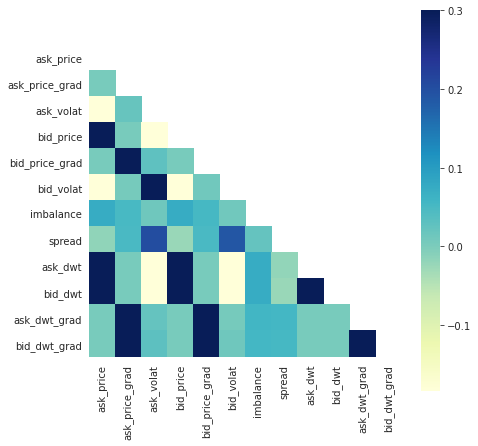

In [213]:
corr = lv1_df_train.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

We can use diagonal covariances because features are not higher correlated. We use median value of 9 components in Gaussian Mixture Model. We use 9 states because assume that each component generates 9 states and there are at most 9 classes produced by OPTICS clustering.

In [30]:
HMM = GMMHMM(n_components=7, n_mix = 8, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(lv1_df_train.values)

We are looking for outliers, so are more interested in the tails of distribution that its center, hence use Anderson Darling test, not Kolmogorov Smirnov. It can be used for different sample sizes.

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

https://stats.stackexchange.com/questions/201434/2-sample-kolmogorov-smirnov-vs-anderson-darling-vs-cramer-von-mises#:~:text=Anderson-Darling%20test%20is%20much,get%20much%20more%20powerful%20test.

In [18]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
states = np.full((lv1_df.shape[0], 12), -1, dtype ='float64')
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df.shape[0] - end >= sliding_window:
        dataset = lv1_df.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        if end > train_size:
            temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
            for cc in lv1_df.columns:
                ADtest = anderson_ksamp(np.array([temp_df[cc],lv1_df_train[cc]]).T)
                if ADtest[0] > ADtest[1][4]: #test at 1% significance
                    print(temp_df.shape)
                    HMM = GMMHMM(n_components=7, n_mix = 8, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset[c]).reshape(-1, 1), algorithm='viterbi')
            if h == 0:
                states[:end, pos] = st
            else:
                states[end-sliding_window:end, pos] = st[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
        for cc in dataset.columns:
                ADtest = anderson_ksamp(np.array([temp_df[cc],lv1_df_train[cc]]).T)
                if ADtest[0] > ADtest[1][4]: #test at 1% significance
                    HMM = GMMHMM(n_components=7, n_mix = 8, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset[c]).reshape(-1, 1), algorithm='viterbi')
            states[-(lv1_df.shape[0] - end):, pos] = st[-(lv1_df.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-26 03:52:55
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 12)
(10234, 

KeyboardInterrupt: 

In [216]:
states_df = pd.DataFrame(states, columns=lv1_df.columns)
states_df

ValueError: Shape of passed values is (17537, 12), indices imply (17537, 8)

In [25]:
states[:-10,:][4]

array([2., 2., 4., 2., 2., 4., 2., 2., 2., 2., 2., 2.])